In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium  
import os
import esda 
import libpysal as lps
import seaborn as sns
import pysal as ps
import pysal.viz as viz
import mapclassify
from spreg import ML_Error
from spreg import ML_Lag
from libpysal.weights.contiguity import Queen
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR
from mgwr.utils import shift_colormap, truncate_colormap
import statsmodels.api as sm

In [2]:
lsoas = gpd.read_file(os.path.join('..','data','LDN-LSOAs.shp'))
lsoas.sample(3)

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
3629  E01003713             Redbridge 034A             Redbridge 034A   
3191  E01003262              Lewisham 021E              Lewisham 021E   
2911  E01002977  Kingston upon Thames 012B  Kingston upon Thames 012B   

      objectid     st_areasha   st_lengths  \
3629      3630  145747.394121  2058.390980   
3191      3192  160607.517567  2148.409269   
2911      2912  300345.290634  4028.923980   

                                               geometry  
3629  POLYGON ((546113.976 186954.014, 546124.542 18...  
3191  POLYGON ((535498.875 173823.554, 535520.806 17...  
2911  POLYGON ((521626.960 166838.103, 521581.594 16...

In [3]:
lsoas.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_OSGB 1936 ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [4]:
mtwt = pd.read_csv(os.path.join('..','data','Method to Work Total.csv'))
mtwt.sample(3)

All usual residents aged 16 or over in employment the week before the Census  \
6193             E01012986 East Riding of Yorkshire 010A                             
12010                       E01026249 South Holland 010B                             
33011                          W01001388 Caerphilly 007D                             

       LSOA Code  Total  Mainly work at or from home  \
6193   E01012986    670                          143   
12010  E01026249    903                          175   
33011  W01001388    754                           58   

       Underground, metro, light rail, tram  Train  Bus; minibus or coach  \
6193                                      0      1                      4   
12010                                     1      8                     10   
33011                                     0     13                     19   

       Taxi  Motorcycle; scooter or moped  Driving a car or van  \
6193      0                             2                   462   
12010     2                             3                   626   
33011     1                             3                   538   

       Passenger in car or van  Bicycle  On foot  \
6193                        26        7       24   
12010                       43       13       19   
33011                       71        0       46   

       Other method of travel to work  
6193                                1  
12010                               3  
33011                               5

In [5]:
ptai = pd.read_csv(os.path.join('..','data','LSOA2011 AvPTAI2015.csv'))
ptai.sample(3)

LSOA2011  AvPTAI2015     PTAL  PTAIHigh  PTAILow
2970  E01003037    13.99050  3.00000   18.2410  9.79803
2602  E01002661     9.89294  2.00000   22.0398  1.92906
3756  E01003841     3.71158       1b    6.2212  0.00000

In [6]:
ptai = ptai.drop(columns=['PTAIHigh','PTAILow'])
ptai

LSOA2011  AvPTAI2015     PTAL
0     E01000001    69.82330       6b
1     E01000002    83.78200       6b
2     E01000003    41.74170       6b
3     E01000005    85.88930       6b
4     E01000006    22.45580  5.00000
...         ...         ...      ...
4830  E01033742     3.95321       1b
4831  E01033743     3.81744       1b
4832  E01033744    10.17090  3.00000
4833  E01033745     4.68378       1b
4834  E01033746    18.98820  4.00000

[4835 rows x 3 columns]

In [7]:
ptai.describe()

AvPTAI2015
count  4835.000000
mean     13.340793
std      12.540079
min       0.191140
25%       5.488570
50%       9.514610
75%      17.000350
max     121.887000

In [8]:
median = pd.read_csv(os.path.join('..','data','2019_median_age_LSOA.csv'))
median.sample(3)
median_df = median[['LSOA Code','Median Age']]
median_df.sample(3)

LSOA Code  Median Age
20603  E01029930          48
3033   E01014939          38
32620  E01004555          35

In [9]:
median_df.describe()

Median Age
count  34753.000000
mean      42.104077
std        7.853807
min       15.000000
25%       36.000000
50%       42.000000
75%       48.000000
max       72.000000

In [10]:
CT0462_Females = pd.read_csv(os.path.join('..','data','CT0462 - Females.csv'))
CT0462_Females_df = CT0462_Females[[
    'LSOA Code',
    'Total']]
CT0462_Females_df = CT0462_Females_df.rename(
    columns={
        'LSOA Code':'LSOA Code',
        'Total':'Work_Female'
    })
# CT0462_Females_df['Work_Female'].str.replace(',', '').astype(int).dtypes
CT0462_Females_df.sample(3)

LSOA Code  Work_Female
17684  E01026629        331.0
17698  E01026640        267.0
28136  E01024481        356.0

In [11]:
CT0462_Males = pd.read_csv(os.path.join('..','data','CT0462 - Males.csv'))
CT0462_Males_df = CT0462_Males[[
    'LSOA Code',
    'Total']]
CT0462_Males_df = CT0462_Males_df.rename(
    columns={
        'LSOA Code':'LSOA Code',
        'Total':'Work_Male'
    })
# CT0462_Males_df['Work_Male'].astype('int').dtypes
CT0462_Females_df.sample(3)

LSOA Code  Work_Female
27498  E01024387        568.0
21013  E01001605        388.0
19235  E01030268        299.0

In [12]:
atlas = pd.read_csv(os.path.join('..','data','lsoa-data.csv'), encoding= 'unicode_escape')
atlas

/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (174,175,176,178,189,253,254) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Lower Super Output Area                Names  \
0                  E01000907          Camden 001A   
1                  E01000908          Camden 001B   
2                  E01000909          Camden 001C   
3                  E01000912          Camden 001D   
4                  E01000913          Camden 001E   
...                      ...                  ...   
4832               E01004330  Waltham Forest 028D   
4833               E01004331  Waltham Forest 028E   
4834               E01004332  Waltham Forest 028F   
4835                     NaN                  NaN   
4836                     NaN                  NaN   

      Mid-year Population Estimates;All Ages;2001  \
0                                          1519.0   
1                                          1547.0   
2                                          1600.0   
3                                          1738.0   
4                                          1617.0   
...                                           ...   
4832                                       1524.0   
4833                                       1490.0   
4834                                       1543.0   
4835                                          NaN   
4836                                          NaN   

      Mid-year Population Estimates;All Ages;2002  \
0                                          1538.0   
1                                          1577.0   
2                                          1598.0   
3                                          1728.0   
4                                          1676.0   
...                                           ...   
4832                                       1447.0   
4833                                       1510.0   
4834                                       1575.0   
4835                                          NaN   
4836                                          NaN   

      Mid-year Population Estimates;All Ages;2003  \
0                                          1528.0   
1                                          1605.0   
2                                          1618.0   
3                                          1678.0   
4                                          1662.0   
...                                           ...   
4832                                       1439.0   
4833                                       1513.0   
4834                                       1631.0   
4835                                          NaN   
4836                                          NaN   

      Mid-year Population Estimates;All Ages;2004  \
0                                          1547.0   
1                                          1637.0   
2                                          1634.0   
3                                          1707.0   
4                                          1714.0   
...                                           ...   
4832                                       1504.0   
4833                                       1582.0   
4834                                       1616.0   
4835                                          NaN   
4836                                          NaN   

      Mid-year Population Estimates;All Ages;2005  \
0                                          1593.0   
1                                          1629.0   
2                                          1610.0   
3                                          1710.0   
4                                          1705.0   
...                                           ...   
4832                                       1529.0   
4833                                       1587.0   
4834                                       1601.0   
4835                                          NaN   
4836                                          NaN   

      Mid-year Population Estimates;All Ages;2006  \
0                                          1492.0   
1                                          1598.0   
2                       

In [13]:
atlas.dtypes

Lower Super Output Area                         object
Names                                           object
Mid-year Population Estimates;All Ages;2001    float64
Mid-year Population Estimates;All Ages;2002    float64
Mid-year Population Estimates;All Ages;2003    float64
                                                ...   
Road Casualties;2013;2013 Total                float64
Road Casualties;2014;Fatal                     float64
Road Casualties;2014;Serious                   float64
Road Casualties;2014;Slight                    float64
Road Casualties;2014;2014 Total                float64
Length: 277, dtype: object

In [14]:
atlas['car'] = (
    (
        atlas['Car or van availability;No cars or vans in household;2011']*0+
        atlas['Car or van availability;1 car or van in household;2011']*1+
        atlas['Car or van availability;2 cars or vans in household;2011']*2+
        atlas['Car or van availability;3 cars or vans in household;2011']*3+
        atlas['Car or van availability;4 or more cars or vans in household;2011']*4
    )/(
        atlas['Car or van availability;No cars or vans in household;2011']+
        atlas['Car or van availability;1 car or van in household;2011']+
        atlas['Car or van availability;2 cars or vans in household;2011']+
        atlas['Car or van availability;3 cars or vans in household;2011']+
        atlas['Car or van availability;4 or more cars or vans in household;2011']
    )
)

In [15]:
atlas_df = atlas[['Lower Super Output Area','Household Income, 2011/12;Median Annual Household Income estimate (£)','car']]
atlas_df =atlas_df.rename(columns={'Lower Super Output Area': 'lsoa code', 
'Household Income, 2011/12;Median Annual Household Income estimate (£)': 'income'})
atlas_df = atlas_df.dropna()
atlas_df['lg_income'] = np.log10(atlas_df['income'])
atlas_df

lsoa code   income       car  lg_income
0     E01000907  30223.0  0.456140   4.480338
1     E01000908  32049.0  0.475212   4.505814
2     E01000909  58469.0  0.865356   4.766926
3     E01000912  31551.0  0.430000   4.499013
4     E01000913  73024.0  1.229917   4.863466
...         ...      ...       ...        ...
4830  E01004328  28402.0  0.612519   4.453349
4831  E01004329  26907.0  0.713860   4.429865
4832  E01004330  30026.0  0.792000   4.477497
4833  E01004331  26598.0  0.681481   4.424849
4834  E01004332  26677.0  0.598736   4.426137

[4835 rows x 4 columns]

In [16]:
atlas_df.describe()

income          car    lg_income
count   4835.000000  4835.000000  4835.000000
mean   35756.460393     0.843492     4.533291
std    11459.895607     0.363373     0.129368
min    16167.000000     0.157371     4.208629
25%    26996.500000     0.539280     4.431307
50%    32609.000000     0.803448     4.513337
75%    42272.500000     1.104105     4.626058
max    92431.000000     2.137746     4.965818

In [17]:
ptai

LSOA2011  AvPTAI2015     PTAL
0     E01000001    69.82330       6b
1     E01000002    83.78200       6b
2     E01000003    41.74170       6b
3     E01000005    85.88930       6b
4     E01000006    22.45580  5.00000
...         ...         ...      ...
4830  E01033742     3.95321       1b
4831  E01033743     3.81744       1b
4832  E01033744    10.17090  3.00000
4833  E01033745     4.68378       1b
4834  E01033746    18.98820  4.00000

[4835 rows x 3 columns]

In [18]:
mtwt.dtypes

All usual residents aged 16 or over in employment the week before the Census    object
LSOA Code                                                                       object
Total                                                                            int64
Mainly work at or from home                                                      int64
Underground, metro, light rail, tram                                             int64
Train                                                                            int64
Bus; minibus or coach                                                            int64
Taxi                                                                             int64
Motorcycle; scooter or moped                                                     int64
Driving a car or van                                                             int64
Passenger in car or van                                                          int64
Bicycle                                    

In [19]:
# col_name = [
#     'Total', 'Mainly work at or from home',
#        'Underground, metro, light rail, tram', 'Train',
#        'Bus; minibus or coach', 'Taxi', 'Motorcycle; scooter or moped',
#        'Driving a car or van', 'Passenger in car or van', 'Bicycle', 'On foot',
#        'Other method of travel to work'
# ]
# for x in col_name:
#     mtwt[x] = mtwt[x].astype(int)
# mtwt.dtypes

In [20]:
mtwt_gdf = lsoas.merge(mtwt, left_on = 'lsoa11cd', right_on = 'LSOA Code', how = 'left')
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      LSOA Code  Total  ...  Underground, metro, light rail, tram  Train  \
0     E01000001    937  ...                                   179     36   
1     E01000002    919  ...                                   186     44   
2     E01000003    769  ...                                   149     38   
3     E01000005    481  ...                                   107     43   
4     E01000006    781  ...                                   256    105   
...         ...    ...  ...                                   ...    ...   
4830  E01033742    763  ...                                   223    175   
4831  E01033743    819  ...                                   158    122   
4832  E01033744    793  ...                                   156    150   
4833  E01033745    788  ...                                   144    110   
4834  E01033746    794 

In [21]:
mtwt_gdf = mtwt_gdf.merge(ptai, left_on = 'lsoa11cd', right_on = 'LSOA2011', how = 'left')
mtwt_gdf = mtwt_gdf.drop(columns=['LSOA Code'])
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  Taxi  \
0       937                          146  ...    10   
1       919                          155  ...    12   
2       769                           82  ...     2   
3       481                           36  ...     2   
4       781                           61  ...     2   
...     ...                          ...  ...   ...   
4830    763                           48  ...     2   
4831    819                           69  ...     5   
4832    793                           61  ...     4   
4833    788                           61  ...     2   
4834    794                           77  ...     2   

      Motorcycle; scooter or moped  Driving a car or van  \
0                                4                    28   
1                                6                    24   
2                 

In [22]:
mtwt_gdf = mtwt_gdf.merge(atlas_df, left_on = 'lsoa11cd', right_on = 'lsoa code', how = 'left')
# mtwt_gdf = mtwt_gdf.drop(columns=['LSOA Code'])
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  Bicycle  On foot  \
0       937                          146  ...       46      441   
1       919                          155  ...       56      403   
2       769                           82  ...       68      318   
3       481                           36  ...       32      157   
4       781                           61  ...        7       59   
...     ...                          ...  ...      ...      ...   
4830    763                           48  ...       16       37   
4831    819                           69  ...        7       17   
4832    793                           61  ...       15       60   
4833    788                           61  ...        8       31   
4834    794                           77  ...       32       51   

      Other method of travel to work   LSOA2011  AvPTA

In [23]:
mtwt_gdf = mtwt_gdf.merge(median_df, left_on = 'lsoa11cd', right_on = 'LSOA Code', how = 'left')
# mtwt_gdf = mtwt_gdf.drop(columns=['LSOA Code'])
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  Other method of travel to work  \
0       937                          146  ...                               9   
1       919                          155  ...                              10   
2       769                           82  ...                               9   
3       481                           36  ...                               1   
4       781                           61  ...                               2   
...     ...                          ...  ...                             ...   
4830    763                           48  ...                              32   
4831    819                           69  ...                               3   
4832    793                           61  ...                               6   
4833    788                           61  ...    

In [24]:
mtwt_gdf = mtwt_gdf.merge(CT0462_Females_df, left_on = 'lsoa11cd', right_on = 'LSOA Code', how = 'left')
# mtwt_gdf = mtwt_gdf.drop(columns=['LSOA Code'])
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  AvPTAI2015     PTAL  lsoa code  \
0       937                          146  ...    69.82330       6b  E01000001   
1       919                          155  ...    83.78200       6b  E01000002   
2       769                           82  ...    41.74170       6b  E01000003   
3       481                           36  ...    85.88930       6b  E01000005   
4       781                           61  ...    22.45580  5.00000  E01000006   
...     ...                          ...  ...         ...      ...        ...   
4830    763                           48  ...     3.95321       1b  E01033742   
4831    819                           69  ...     3.81744       1b  E01033743   
4832    793                           61  ...    10.17090  3.00000  E01033744   
4833    788                           61  ...    

In [25]:
mtwt_gdf = mtwt_gdf.merge(CT0462_Males_df, left_on = 'lsoa11cd', right_on = 'LSOA Code', how = 'left')
# mtwt_gdf = mtwt_gdf.drop(columns=['LSOA Code'])
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  lsoa code   income       car  \
0       937                          146  ...  E01000001  58347.0  0.515982   
1       919                          155  ...  E01000002  57159.0  0.515663   
2       769                           82  ...  E01000003  34387.0  0.220318   
3       481                           36  ...  E01000005  24000.0  0.265525   
4       781                           61  ...  E01000006  39141.0  0.907919   
...     ...                          ...  ...        ...      ...       ...   
4830    763                           48  ...  E01033742  37255.0  0.671256   
4831    819                           69  ...  E01033743  30237.0  0.787330   
4832    793                           61  ...  E01033744  27670.0  0.664087   
4833    788                           61  ...  E01033745  31450.0  0.

In [26]:
mtwt_gdf.dtypes

lsoa11cd                                                                          object
lsoa11nm                                                                          object
lsoa11nmw                                                                         object
objectid                                                                           int64
st_areasha                                                                       float64
st_lengths                                                                       float64
geometry                                                                        geometry
All usual residents aged 16 or over in employment the week before the Census      object
Total                                                                              int64
Mainly work at or from home                                                        int64
Underground, metro, light rail, tram                                               int64
Train                

In [27]:
mtwt_gdf.columns

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'objectid', 'st_areasha',
       'st_lengths', 'geometry',
       'All usual residents aged 16 or over in employment the week before the Census',
       'Total', 'Mainly work at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus; minibus or coach', 'Taxi', 'Motorcycle; scooter or moped',
       'Driving a car or van', 'Passenger in car or van', 'Bicycle', 'On foot',
       'Other method of travel to work', 'LSOA2011', 'AvPTAI2015', 'PTAL',
       'lsoa code', 'income', 'car', 'lg_income', 'LSOA Code_x', 'Median Age',
       'LSOA Code_y', 'Work_Female', 'LSOA Code', 'Work_Male'],
      dtype='object')

In [28]:
mtwt_gdf['Method'] = (
    mtwt_gdf['On foot'] + 
    mtwt_gdf['Bicycle']*2 +
    mtwt_gdf['Underground, metro, light rail, tram']*8 +
    mtwt_gdf['Train']*8 +
    mtwt_gdf['Motorcycle; scooter or moped']*10 +
    mtwt_gdf['Bus; minibus or coach']*8 +
    mtwt_gdf['Driving a car or van']*30 +
    mtwt_gdf['Passenger in car or van']*29 +
    mtwt_gdf['Taxi']*31
)/(
    mtwt_gdf['Total']-
    mtwt_gdf['Mainly work at or from home']-
    mtwt_gdf['Other method of travel to work']
)
mtwt_gdf


lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...   income       car  lg_income  \
0       937                          146  ...  58347.0  0.515982   4.766019   
1       919                          155  ...  57159.0  0.515663   4.757085   
2       769                           82  ...  34387.0  0.220318   4.536394   
3       481                           36  ...  24000.0  0.265525   4.380211   
4       781                           61  ...  39141.0  0.907919   4.592632   
...     ...                          ...  ...      ...       ...        ...   
4830    763                           48  ...  37255.0  0.671256   4.571185   
4831    819                           69  ...  30237.0  0.787330   4.480539   
4832    793                           61  ...  27670.0  0.664087   4.442009   
4833    788                           61  ...  31450.0  0.927242   4.

In [29]:
mtwt_gdf['Sex Ratio'] = (mtwt_gdf['Work_Male'])/mtwt_gdf['Work_Female']
mtwt_gdf

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...       car  lg_income  \
0       937                          146  ...  0.515982   4.766019   
1       919                          155  ...  0.515663   4.757085   
2       769                           82  ...  0.220318   4.536394   
3       481                           36  ...  0.265525   4.380211   
4       781                           61  ...  0.907919   4.592632   
...     ...                          ...  ...       ...        ...   
4830    763                           48  ...  0.671256   4.571185   
4831    819                           69  ...  0.787330   4.480539   
4832    793                           61  ...  0.664087   4.442009   
4833    788                           61  ...  0.927242   4.497621   
4834    794                           77  ...  0.588811   4.693560   

      LSOA Code_x 

In [30]:
mtwt_gdf.describe()

objectid    st_areasha    st_lengths        Total  \
count   4835.000000  4.835000e+03   4835.000000  4835.000000   
mean    3520.121613  3.254407e+05   3085.799402   831.805791   
std     6024.336492  6.290090e+05   1673.249789   181.391908   
min        1.000000  1.690171e+04    681.045115   362.000000   
25%     1209.500000  1.335480e+05   2106.779742   713.000000   
50%     2418.000000  2.033552e+05   2716.723592   805.000000   
75%     3626.500000  3.190558e+05   3569.477035   931.500000   
max    32822.000000  1.580873e+07  23353.894442  1828.000000   

       Mainly work at or from home  Underground, metro, light rail, tram  \
count                  4835.000000                           4835.000000   
mean                     80.144984                            181.005377   
std                      34.944934                            141.507080   
min                      17.000000                              2.000000   
25%                      55.000000                             67.000000   
50%                      72.000000                            152.000000   
75%                      99.000000                            259.500000   
max                     324.000000                            978.000000   

             Train  Bus; minibus or coach         Taxi  \
count  4835.000000            4835.000000  4835.000000   
mean    107.092658             113.170838     3.897415   
std      90.035499              67.565799     4.560518   
min       6.000000               5.000000     0.000000   
25%      43.000000              64.000000     1.000000   
50%      72.000000              99.000000     3.000000   
75%     146.000000             148.000000     5.000000   
max     696.000000             503.000000    73.000000   

       Motorcycle; scooter or moped  ...  Other method of travel to work  \
count                   4835.000000  ...                     4835.000000   
mean                       9.131127  ...                        4.335057   
std                        6.251601  ...                        4.612031   
min                        0.000000  ...                        0.000000   
25%                        5.000000  ...                        2.000000   
50%                        8.000000  ...                        4.000000   
75%                       12.000000  ...                        6.000000   
max                       53.000000  ...                      177.000000   

        AvPTAI2015        income          car    lg_income   Median Age  \
count  4835.000000   4835.000000  4835.000000  4835.000000  4835.000000   
mean     13.340793  35756.460393     0.843492     4.533291    36.831024   
std      12.540079  11459.895607     0.363373     0.129368     4.708529   
min       0.191140  16167.000000     0.157371     4.208629    18.000000   
25%       5.488570  26996.500000     0.539280     4.431307    34.000000   
50%       9.514610  32609.000000     0.803448     4.513337    36.000000   
75%      17.000350  42272.500000     1.104105     4.626058    39.000000   
max     121.887000  92431.000000     2.137746     4.965818    60.000000   

       Work_Female    Work_Male       Method    Sex Ratio  
count  4835.000000  4835.000000  4835.000000  4835.000000  
mean    387.382627   444.423164    14.360426     1.159601  
std      88.034914   103.289318     4.130115     0.188258  
min     155.000000   179.000000     4.163910     0.718750  
25%     329.000000   376.000000    10.724587     1.046081  
50%     376.000000   430.000000    14.140669     1.124122  
75%     436.000000   500.000000    17.925293     1.227213  
max     943.000000  1004.000000    24.685908     2.833333  

[8 rows x 24 columns]

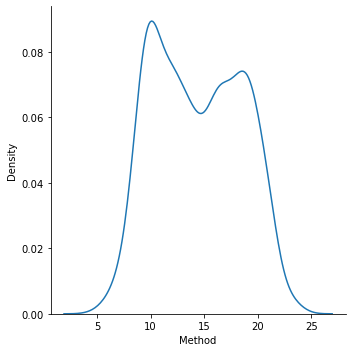

In [31]:
sns.displot(mtwt_gdf['Method'], kind="kde")

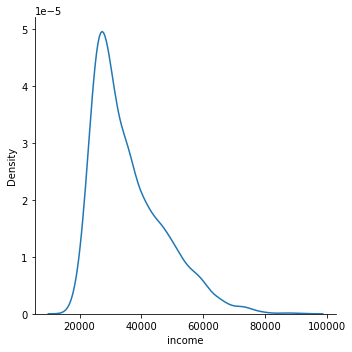

In [33]:
sns.displot(mtwt_gdf['income'], kind="kde")

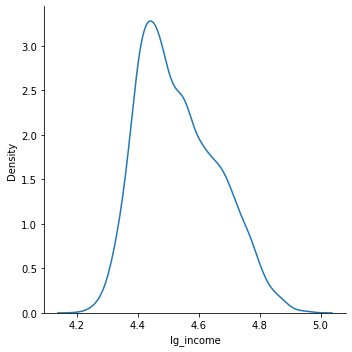

In [34]:
sns.displot(mtwt_gdf['lg_income'], kind="kde")

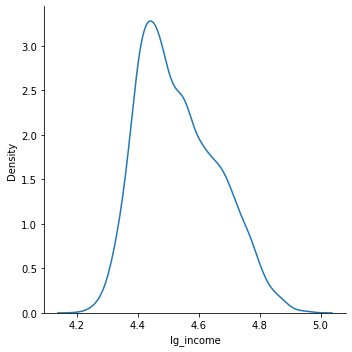

In [35]:
X = mtwt_gdf['lg_income']
g_X = (X - X.mean()) / X.std()
sns.displot(X, kind="kde")

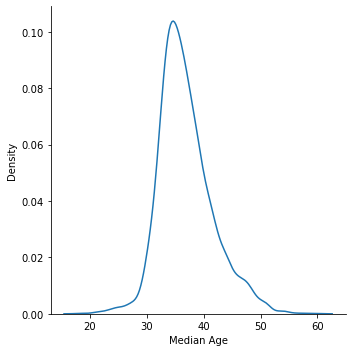

In [36]:
sns.displot(mtwt_gdf['Median Age'], kind="kde")

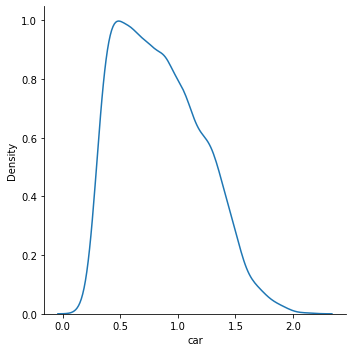

In [37]:
sns.displot(mtwt_gdf['car'], kind="kde")

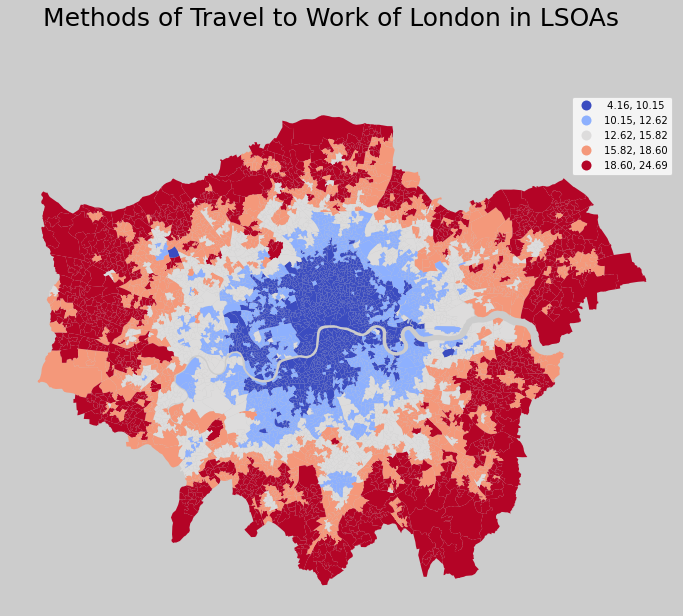

In [38]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='Method', scheme='Quantiles',k = 5, cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Methods of Travel to Work of London in LSOAs', size=25)

plt.show()

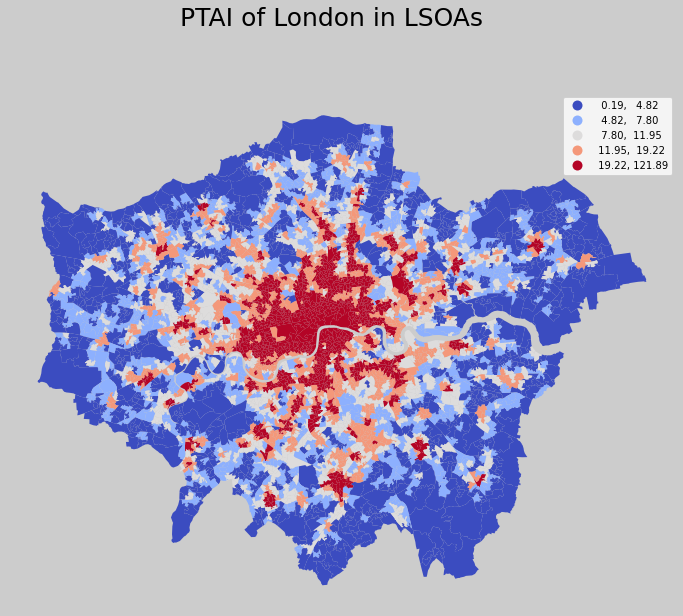

In [39]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='AvPTAI2015', scheme='Quantiles', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('PTAI of London in LSOAs', size=25)

plt.show()

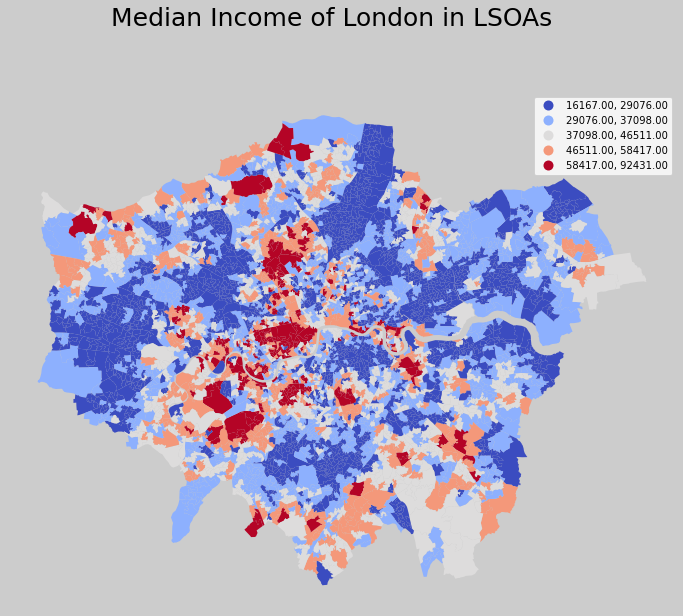

In [40]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='income', scheme='fisher_jenks', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Median Income of London in LSOAs', size=25)

plt.show()

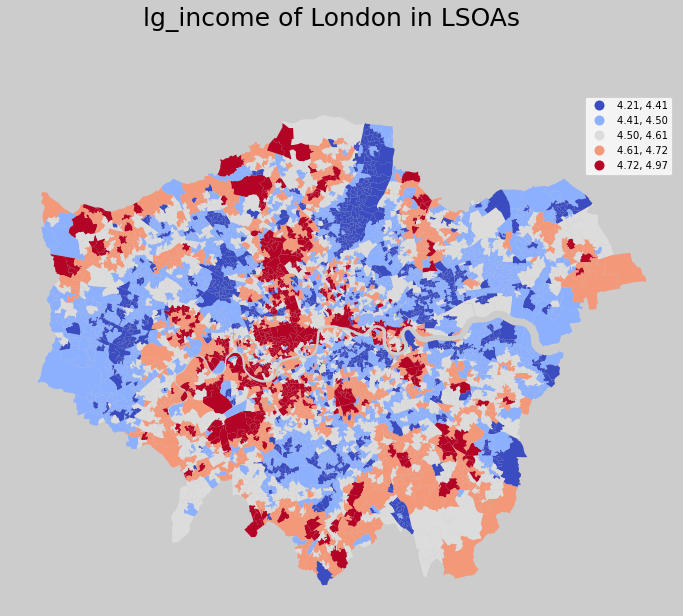

In [41]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='lg_income', scheme='fisher_jenks', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('lg_income of London in LSOAs', size=25)

plt.show()

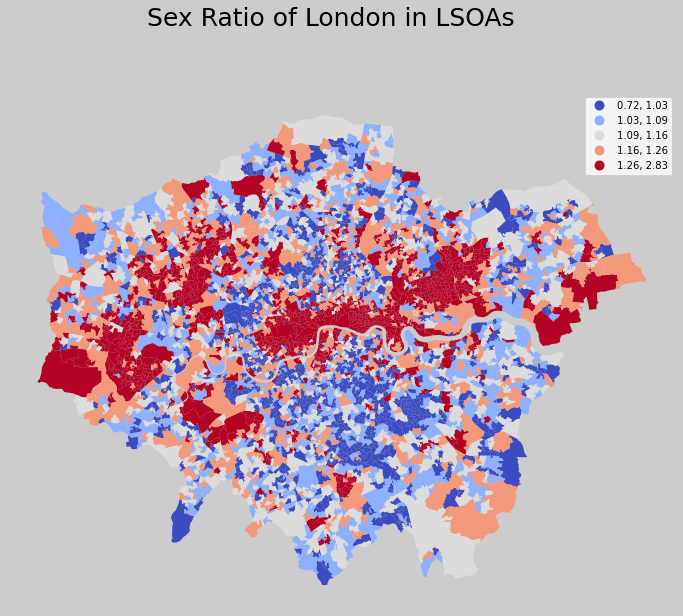

In [42]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='Sex Ratio', scheme='Quantiles', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Sex Ratio of London in LSOAs', size=25)

plt.show()

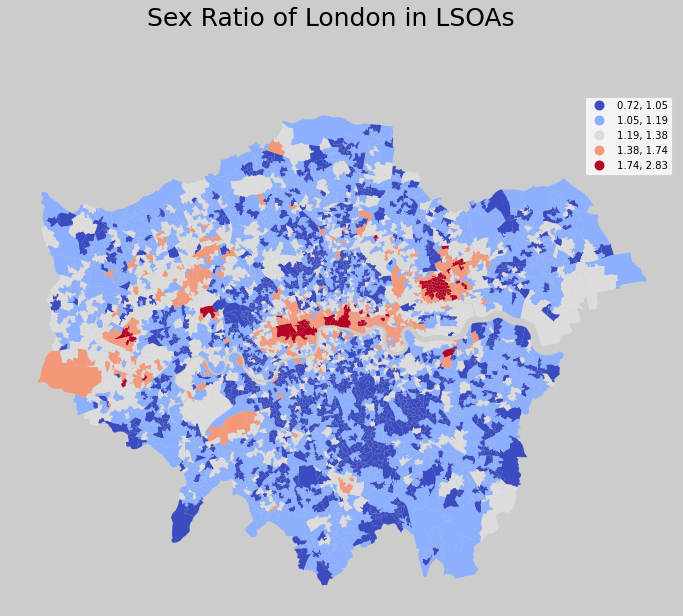

In [43]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='Sex Ratio', scheme='fisher_jenks', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Sex Ratio of London in LSOAs', size=25)

plt.show()

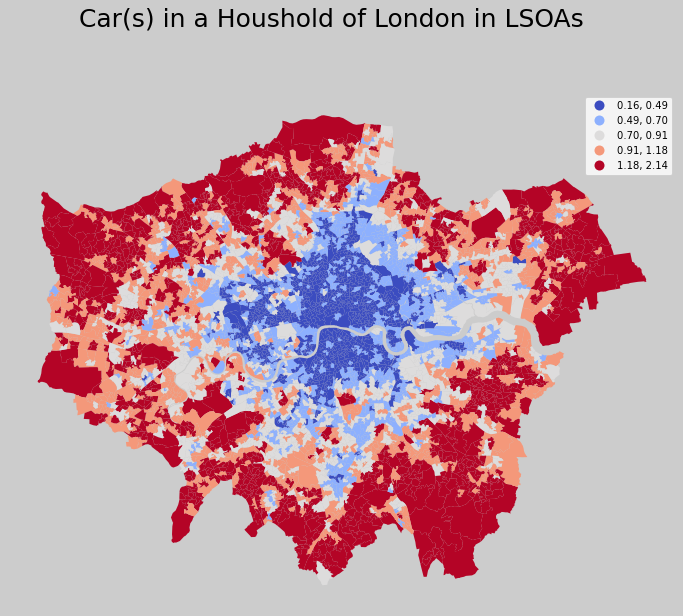

In [44]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='car', scheme='Quantiles', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Car(s) in a Houshold of London in LSOAs', size=25)

plt.show()

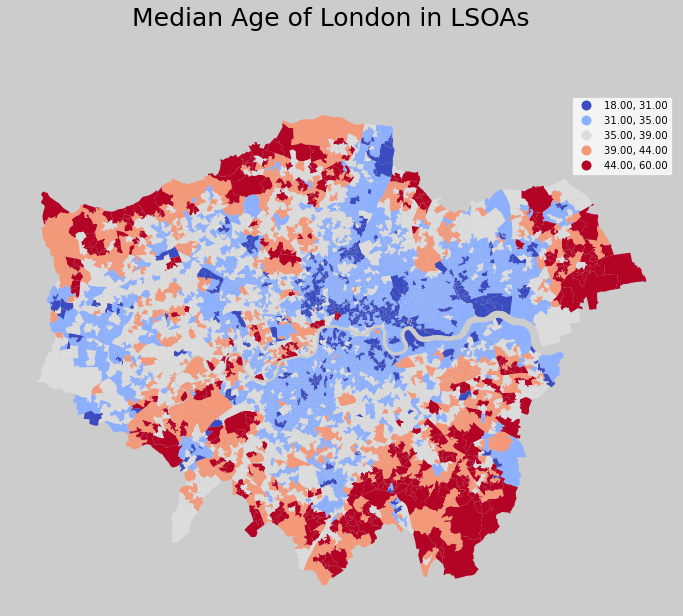

In [45]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
mtwt_gdf.plot(column='Median Age', scheme='fisher_jenks', cmap='coolwarm',legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('Median Age of London in LSOAs', size=25)

plt.show()

In [47]:
mtwt_gdf[['Method','lg_income','AvPTAI2015','car','Sex Ratio','Median Age']].describe()

Method    lg_income   AvPTAI2015          car    Sex Ratio  \
count  4835.000000  4835.000000  4835.000000  4835.000000  4835.000000   
mean     14.360426     4.533291    13.340793     0.843492     1.159601   
std       4.130115     0.129368    12.540079     0.363373     0.188258   
min       4.163910     4.208629     0.191140     0.157371     0.718750   
25%      10.724587     4.431307     5.488570     0.539280     1.046081   
50%      14.140669     4.513337     9.514610     0.803448     1.124122   
75%      17.925293     4.626058    17.000350     1.104105     1.227213   
max      24.685908     4.965818   121.887000     2.137746     2.833333   

        Median Age  
count  4835.000000  
mean     36.831024  
std       4.708529  
min      18.000000  
25%      34.000000  
50%      36.000000  
75%      39.000000  
max      60.000000

<AxesSubplot:>

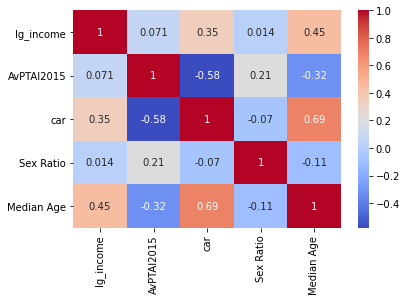

In [48]:
corr= mtwt_gdf[['lg_income','AvPTAI2015','car','Sex Ratio','Median Age']].corr()
# corr.style.background_gradient(cmap='coolwarm')
sns.heatmap(corr, cmap='coolwarm', annot=True)

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = mtwt_gdf[['lg_income','AvPTAI2015','car','Sex Ratio','Median Age']].assign(const=1)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

lg_income        1.412051
AvPTAI2015       1.808690
car              2.795320
Sex Ratio        1.067722
Median Age       2.124736
const         1508.360133
dtype: float64

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = mtwt_gdf[['lg_income','AvPTAI2015','car','Sex Ratio','Median Age']].assign(const=1)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

lg_income        1.412051
AvPTAI2015       1.808690
car              2.795320
Sex Ratio        1.067722
Median Age       2.124736
const         1508.360133
dtype: float64

In [63]:
x = ['lg_income','AvPTAI2015'] # define input/independant variables
y = np.array(mtwt_gdf['Method'])
X = mtwt_gdf.loc[:, x].dropna()
X
X = sm.add_constant(X)
ols1 = sm.OLS(y, X).fit()
# predictions = model.predict(X)
# Print out the statistics
ols1.summary()

/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1848.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:20:35   Log-Likelihood:                -12344.
No. Observations:                4835   AIC:                         2.469e+04
Df Residuals:                    4832   BIC:                         2.471e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1921      1.569     14.142      0.000      19.116      25.268
lg_income     -1.0928      0.347     -3.153      0.002      -1.772      -0.413
AvPTAI2015    -0.2157      0.004    -60.331      0.000      -0.223      -0.209
==============================================================================
Omnibus:                       39.967   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.309
Skew:                           0.190   Prob(JB):                     4.80e-09
Kurtosis:                       2.786   Cond. No.                         669.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
W_queen = lps.weights.Queen.from_dataframe(mtwt_gdf)

In [65]:
I_resid = esda.Moran(ols1.resid, W_queen)  # Moran's I
I_resid.I, I_resid.p_sim, I_resid.EI

(0.832302953674609, 0.001, -0.0002068680182043856)

In [66]:
x = ['lg_income','AvPTAI2015','car'] # define input/independant variables
y = np.array(mtwt_gdf['Method'])
X = mtwt_gdf.loc[:, x].dropna()
X
X = sm.add_constant(X)
ols2 = sm.OLS(y, X).fit()
# predictions = model.predict(X)
# Print out the statistics
ols2.summary()

/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.543e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:20:36   Log-Likelihood:                -8014.7
No. Observations:                4835   AIC:                         1.604e+04
Df Residuals:                    4831   BIC:                         1.606e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3672      0.696     92.473      0.000      63.003      65.732
lg_income    -12.9883      0.161    -80.699      0.000     -13.304     -12.673
AvPTAI2015    -0.0240      0.002    -12.525      0.000      -0.028      -0.020
car           10.8983      0.070    155.348      0.000      10.761      11.036
==============================================================================
Omnibus:                       70.253   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.487
Skew:                           0.264   Prob(JB):                     2.46e-17
Kurtosis:                       3.317   Cond. No.                         729.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
I_resid = esda.Moran(ols2.resid, W_queen)  # Moran's I
I_resid.I, I_resid.p_sim, I_resid.EI

(0.5126979612704954, 0.001, -0.0002068680182043856)

Text(0.5, 0, "Moran's I")

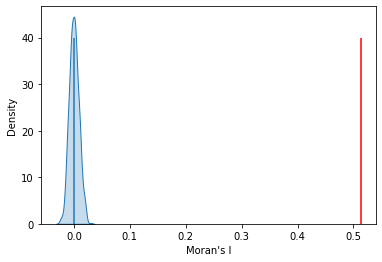

In [68]:
sns.kdeplot(I_resid.sim, shade=True)
plt.vlines(I_resid.I, 0, 40, color='r')
plt.vlines(I_resid.EI, 0, 40)
plt.xlabel("Moran's I")

In [71]:
x = ['lg_income','AvPTAI2015','car','Sex Ratio'] # define input/independant variables
y = np.array(mtwt_gdf['Method'])
X = mtwt_gdf.loc[:, x].dropna()
X
X = sm.add_constant(X)
ols5 = sm.OLS(y, X).fit()
# predictions = model.predict(X)
# Print out the statistics
ols5.summary()

/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:21:28   Log-Likelihood:                -7986.0
No. Observations:                4835   AIC:                         1.598e+04
Df Residuals:                    4830   BIC:                         1.601e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.3743      0.705     92.787      0.000      63.993      66.756
lg_income    -13.0348      0.160    -81.403      0.000     -13.349     -12.721
AvPTAI2015    -0.0208      0.002    -10.687      0.000      -0.025      -0.017
car           10.9397      0.070    156.377      0.000      10.803      11.077
Sex Ratio     -0.7534      0.099     -7.605      0.000      -0.948      -0.559
==============================================================================
Omnibus:                       93.958   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.967
Skew:                           0.320   Prob(JB):                     7.21e-23
Kurtosis:                       3.313   Cond. No.                         743.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

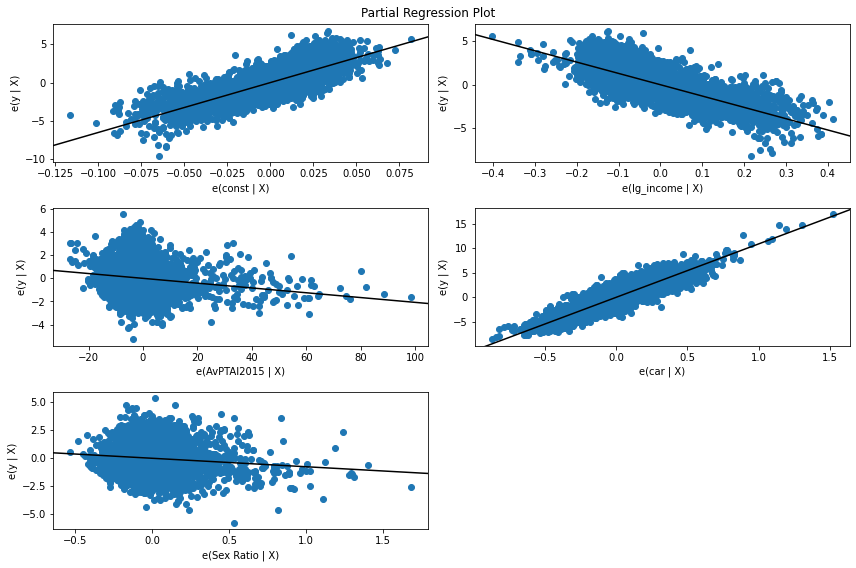

In [72]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(ols5, fig=fig)

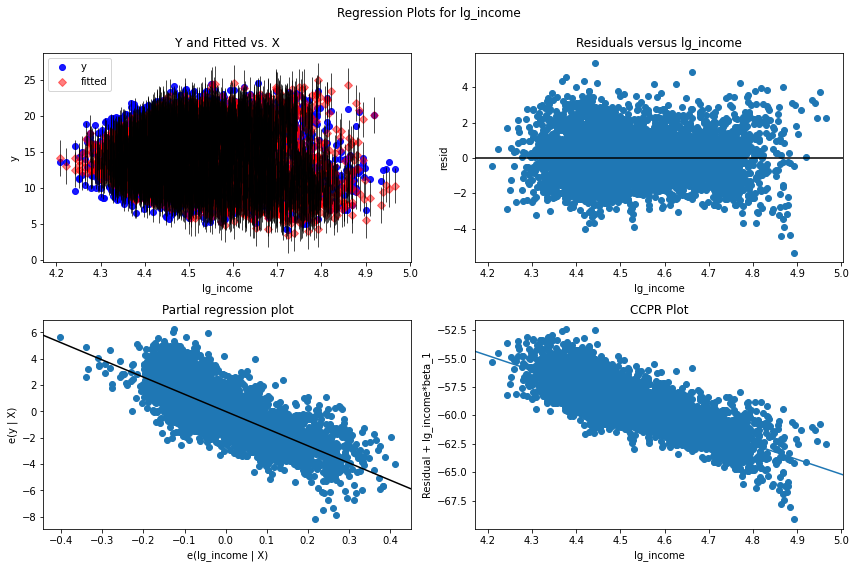

In [73]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(ols5, 'lg_income', fig=fig)

In [86]:
ols5.ssr

7701.376536489262

In [85]:
x = ['lg_income','AvPTAI2015','car','Sex Ratio','Median Age'] # define input/independant variables
y = np.array(mtwt_gdf['Method'])
X = mtwt_gdf.loc[:, x].dropna()
# print(X.geom_type)
X = pd.DataFrame(X)
X = (X - X.mean(axis=0)) / X.std(axis=0)
X = sm.add_constant(X)

y = (y - y.mean(axis=0)) / y.std(axis=0)
ols6 = sm.OLS(y, X).fit()
# predictions = model.predict(X)
# Print out the statistics
ols6.summary()

/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     9380.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:22:07   Log-Likelihood:                -1127.9
No. Observations:                4835   AIC:                             2268.
Df Residuals:                    4829   BIC:                             2307.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.508e-17      0.004  -2.16e-14      1.000      -0.009       0.009
lg_income     -0.4105      0.005    -78.559      0.000      -0.421      -0.400
AvPTAI2015    -0.0635      0.006    -10.744      0.000      -0.075      -0.052
car            0.9566      0.007    130.122      0.000       0.942       0.971
Sex Ratio     -0.0336      0.005     -7.395      0.000      -0.043      -0.025
Median Age     0.0095      0.006      1.478      0.139      -0.003       0.022
==============================================================================
Omnibus:                       93.238   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.796
Skew:                           0.320   Prob(JB):                     1.30e-22
Kurtosis:                       3.301   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Spatial Autocorrelation
### Global

In [87]:
#global Moran
I_methods = esda.Moran(mtwt_gdf['Method'].values, W_queen)  # Moran's I
I_methods.I, I_methods.p_sim 

(0.9371789526514571, 0.001)

In [88]:
print("The Statistic Moran's I is: "+str("%.4f"%I_methods.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%I_methods.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%I_methods.p_norm))

The Statistic Moran's I is: 0.9372 
The Expected Value for Statistic I is: -0.0002 
The Significance Test Value is: 0.0000


Text(0.5, 0, "Moran's I")

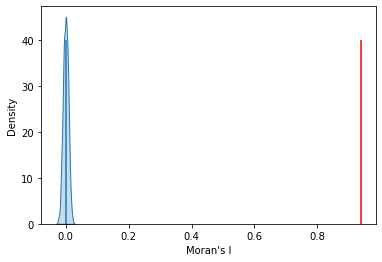

In [89]:
sns.kdeplot(I_methods.sim, shade=True)
plt.vlines(I_methods.I, 0, 40, color='r')
plt.vlines(I_methods.EI, 0, 40)
plt.xlabel("Moran's I")

### Local


In [90]:
lisa = esda.Moran_Local(mtwt_gdf['Method'].values, W_queen, permutations=999)
lisa.Is

array([5.26384733, 5.06462309, 4.62459153, ..., 0.08950918, 0.04829132,
       1.03186429])

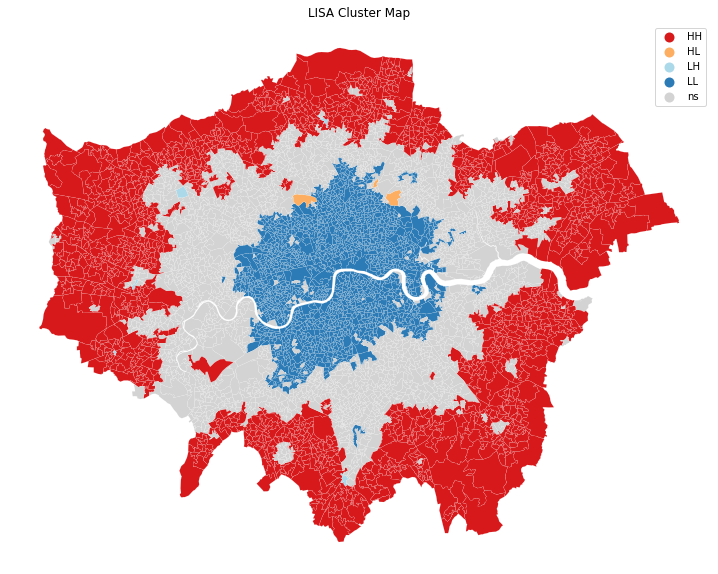

In [91]:
from splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(lisa, mtwt_gdf, ax=ax)
plt.title("LISA Cluster Map")
plt.show()

## GWR

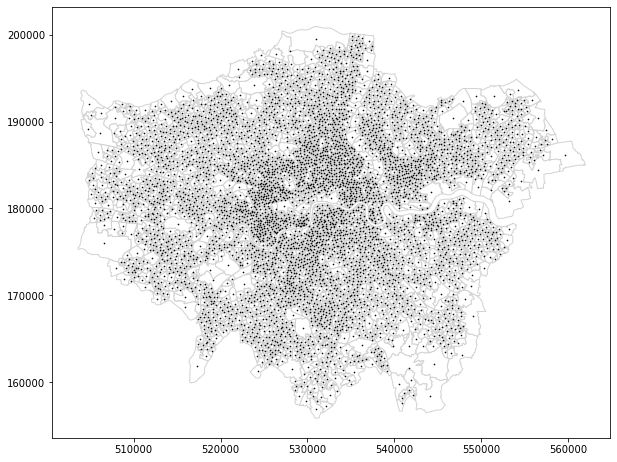

In [92]:
# In spatial data, neighbours is an important concept, let's try and extract centroids of each LSOA
# We can do adjacency analysis based on these centroids
fig, ax = plt.subplots(figsize=(10,10))
mtwt_gdf.plot(ax=ax, **{'edgecolor':'lightgrey', 'facecolor':'white'})

# Plot centroids for each LSOA
mtwt_gdf.centroid.plot(ax=ax, c='black', markersize=0.4)
plt.show()

In [93]:
# Calculating neighbours based on the Queen's contiguity
wq = Queen.from_dataframe(mtwt_gdf)
wq

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

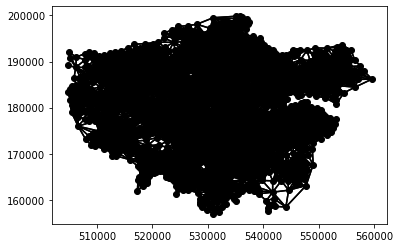

In [94]:
wq.plot(mtwt_gdf)

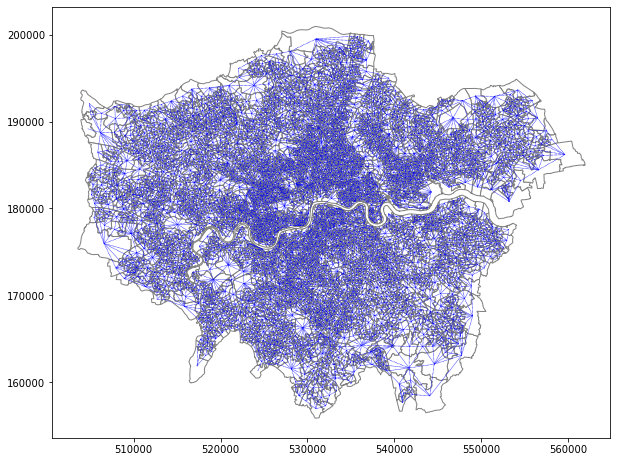

In [95]:
# Calculating neighbours based on the Queen's contiguity
wq = Queen.from_dataframe(mtwt_gdf)

ax = mtwt_gdf.plot(edgecolor='grey', facecolor='w', figsize=(10, 10))
f,ax = wq.plot(lsoas, ax=ax, 
                   edge_kws=dict(color='b', linestyle=':', linewidth=0.5),
                   node_kws=dict(marker=''))

In [96]:
# Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = mtwt_gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [97]:
centroidseries

0       POINT (532151.114 181621.195)
1       POINT (532443.588 181652.016)
2       POINT (532207.300 182036.242)
3       POINT (533618.819 181163.260)
4       POINT (544934.406 184303.632)
                    ...              
4830    POINT (544581.776 179608.642)
4831    POINT (545763.607 180617.554)
4832    POINT (544541.299 179306.637)
4833    POINT (546171.412 180011.543)
4834    POINT (538054.268 177048.061)
Length: 4835, dtype: geometry

In [98]:
#Prepare dataset inputs
g_y = mtwt_gdf['Method'].values.reshape((-1,1))
g_X = mtwt_gdf[['lg_income','AvPTAI2015','car','Sex Ratio']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1 (this standardisation is important so we have normal distribution)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [99]:
# Building our model by assigning adaptive bandwidth
bw = Sel_BW(g_coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)

4827.0

In [100]:
#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
GWR1 = GWR(g_coords, g_y, g_X, gwr_bw).fit()

64.0


In [101]:
# Let's print the result
GWR1.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            451.579
Log-likelihood:                                                   -1128.952
AIC:                                                               2267.903
AICc:                                                              2269.921
BIC:                                                             -40524.385
R2:                                                                   0.907
Adj. R2:                                                              0.907

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [102]:
# We can check the shape of our local parameters array
print(GWR1.params.shape)

(4835, 5)


In [103]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = GWR1.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = GWR1.filter_tvals(alpha=.1)
filtered_estimates99 = GWR1.filter_tvals(alpha=.01)

In [104]:
filtered_estimates

array([[-5.36697334, -3.58335932,  0.        ,  0.        ,  0.        ],
       [-4.97283258, -3.97028371, -2.23069097,  0.        ,  0.        ],
       [-5.38998906, -3.98564546, -3.31869329,  0.        ,  0.        ],
       ...,
       [ 0.        , -7.63959739,  0.        ,  8.83399362, -3.22918846],
       [ 0.        , -8.42765663, -3.87180899,  9.07169655, -2.89051453],
       [-4.70123925, -3.65249864,  0.        ,  3.9263178 ,  0.        ]])

### Viz GWR

In [105]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(GWR1.localR2)

In [106]:
['lg_income','AvPTAI2015','car','Sex Ratio']

['lg_income', 'AvPTAI2015', 'car', 'Sex Ratio']

In [107]:
# Create the new dataframe
df1=pd.DataFrame(mtwt_gdf["lsoa11cd"])
df2 = df1.assign(intercept=data_params[0],
                 income_GWR=data_params[1],
                 PTAI_GWR=data_params[2],
                 car_GWR=data_params[3],
                 sex_GWR = data_params[4]
                 )
df2.columns
df2

lsoa11cd  intercept  income_GWR  PTAI_GWR   car_GWR   sex_GWR
0     E01000001  -5.366973   -3.583359  0.000000  0.000000  0.000000
1     E01000002  -4.972833   -3.970284 -2.230691  0.000000  0.000000
2     E01000003  -5.389989   -3.985645 -3.318693  0.000000  0.000000
3     E01000005  -5.993629   -6.511945 -4.219526  3.596918  0.000000
4     E01000006   6.681320   -3.207196  0.000000  9.290543 -3.925939
...         ...        ...         ...       ...       ...       ...
4830  E01033742   0.000000   -7.654517  0.000000  7.826818 -2.318312
4831  E01033743   0.000000   -8.509654 -3.512454  7.104951 -2.051827
4832  E01033744   0.000000   -7.639597  0.000000  8.833994 -3.229188
4833  E01033745   0.000000   -8.427657 -3.871809  9.071697 -2.890515
4834  E01033746  -4.701239   -3.652499  0.000000  3.926318  0.000000

[4835 rows x 6 columns]

In [108]:
# Merge our shapefile with the model's results
data = mtwt_gdf.copy()
data_final = data.merge(df2, left_on='lsoa11cd', right_on='lsoa11cd')
data_final

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0     E01000001        City of London 001A        City of London 001A   
1     E01000002        City of London 001B        City of London 001B   
2     E01000003        City of London 001C        City of London 001C   
3     E01000005        City of London 001E        City of London 001E   
4     E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...         ...                        ...                        ...   
4830  E01033742             Greenwich 007F             Greenwich 007F   
4831  E01033743             Greenwich 002H             Greenwich 002H   
4832  E01033744             Greenwich 007G             Greenwich 007G   
4833  E01033745             Greenwich 002I             Greenwich 002I   
4834  E01033746             Greenwich 038E             Greenwich 038E   

      objectid    st_areasha   st_lengths  \
0            1  1.333208e+05  2291.846072   
1            2  2.261913e+05  2433.960112   
2            3  5.730297e+04  1142.359799   
3            4  1.907388e+05  2167.868343   
4            5  1.441958e+05  1935.510354   
...        ...           ...          ...   
4830     32818  1.233092e+05  1860.310172   
4831     32819  1.004853e+06  5237.180226   
4832     32820  1.522620e+05  2149.370918   
4833     32821  5.584777e+05  4193.828349   
4834     32822  1.289767e+05  2367.405282   

                                               geometry  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...   
1     POLYGON ((532747.048 181793.042, 532671.921 18...   
2     POLYGON ((532135.385 182204.275, 532158.489 18...   
3     POLYGON ((533808.170 180773.910, 533649.287 18...   
4     POLYGON ((545122.084 184321.013, 545271.951 18...   
...                                                 ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...   

     All usual residents aged 16 or over in employment the week before the Census  \
0                         E01000001 City of London 001A                             
1                         E01000002 City of London 001B                             
2                         E01000003 City of London 001C                             
3                         E01000005 City of London 001E                             
4                   E01000006 Barking and Dagenham 016A                             
...                                                 ...                             
4830                           E01033742 Greenwich 007F                             
4831                           E01033743 Greenwich 002H                             
4832                           E01033744 Greenwich 007G                             
4833                           E01033745 Greenwich 002I                             
4834                           E01033746 Greenwich 038E                             

      Total  Mainly work at or from home  ...  Work_Female  LSOA Code  \
0       937                          146  ...        403.0  E01000001   
1       919                          155  ...        374.0  E01000002   
2       769                           82  ...        316.0  E01000003   
3       481                           36  ...        201.0  E01000005   
4       781                           61  ...        324.0  E01000006   
...     ...                          ...  ...          ...        ...   
4830    763                           48  ...        330.0  E01033742   
4831    819                           69  ...        409.0  E01033743   
4832    793                           61  ...        393.0  E01033744   
4833    788                           61  ...        385.0  E01033745   
4834    794                           77  ...        375

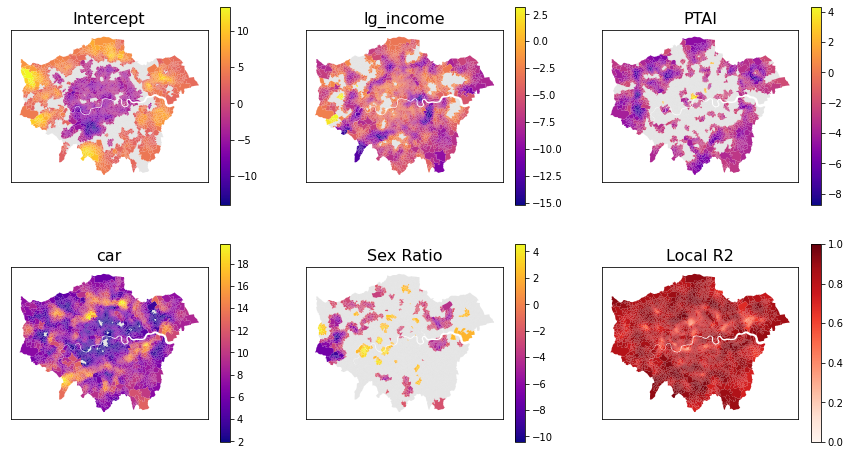

In [109]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,8), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','lg_income','PTAI','car','Sex Ratio' ]

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    data_temp = data_final.assign(toplot=filtered_estimates.T[i])
    (data_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))

    # and assign colours only to the significant estimates
    (data_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

(data_final.assign(r2=GWR1.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'
    ))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    

# f.tight_layout()
    
plt.show()